# 📊 Sprint 2: Trends & Anomalies

In this sprint, we focus on **trend detection and anomaly detection** in support tickets.

## Goals
- Load historical ticket data (Kaggle IT Support dataset)
- Analyze category frequencies and sentiment trends over time
- Detect anomalies in ticket patterns
- Visualize trends with plots

## Dataset Justification
- **Sprint 1 & 3** use `expanded_tickets.json` (small, controlled dataset) for prototyping and explainability.
- **Sprint 2** requires **large-scale, timestamped data** to surface meaningful trends, so we use the **Kaggle IT Support dataset**.
- This demonstrates that our pipeline works on both controlled and real-world data.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys, os
from pathlib import Path
import numpy as np

# Get project root (assuming notebook is in notebooks/)
ROOT = Path(os.getcwd()).resolve().parent
APP_PATH = ROOT / "app"

if str(APP_PATH) not in sys.path:
    sys.path.append(str(APP_PATH))

print("Project root:", ROOT)
print("App path added:", APP_PATH)

Project root: /Users/user/Downloads/hackathon
App path added: /Users/user/Downloads/hackathon/app


In [7]:
from analytics.trend_detector import TrendDetector

trend_detector = TrendDetector()

sns.set(style='whitegrid')

## Load Historical Tickets (Kaggle Dataset)

Assume you have the dataset in `data/it_support_tickets.csv`. If needed, adjust the path.

In [11]:
df = pd.read_csv('dataset-tickets-multi-lang3-4k.csv')

df.columns

Index(['subject', 'body', 'answer', 'type', 'queue', 'priority', 'language',
       'business_type', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6',
       'tag_7', 'tag_8', 'tag_9'],
      dtype='object')

In [15]:
df

,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Estamos investigando urgentemente el problema ...,Incident,Technical Support,high,es,IT Services,Urgent Issue,Service Disruption,Incident Report,Service Recovery,System Maintenance,NaN,NaN,NaN,NaN
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Product Support,Customer Service,Order Issue,Returns and Exchanges,NaN,NaN,NaN,NaN
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...","Prezado <name>,\n\nObrigado por entrar em cont...",Incident,Technical Support,high,pt,IT Services,Technical Support,Software Bug,Problem Resolution,Urgent Issue,IT Support,NaN,NaN,NaN,NaN
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...","Dear <name>,\n\nThank you for reaching out reg...",Request,IT Support,high,en,IT Services,IT Support,Urgent Issue,Service Notification,Cloud Services,Problem Resolution,Technical Guidance,Performance Tuning,NaN,NaN
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Product Support,low,fr,Tech Online Store,Technical Support,Product Support,Hardware Failure,Service Recovery,Routine Request,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Problem mit der HP DeskJet 3755 WLAN-Verbindung,"Sehr geehrter Tech Online Store Support, mein ...","Sehr geehrter <name>, bitte stellen Sie sicher...",Problem,Customer Service,low,de,Tech Online Store,Technical Support,Product Support,Hardware Failure,Network Issue,Problem Resolution,NaN,NaN,NaN,NaN
3996,Problemas com a impressora HP DeskJet 3755,"Olá Suporte ao Cliente,\n\nEstou escrevendo pa...",Assunto: Re: Problemas com a impressora HP Des...,Incident,Product Support,medium,pt,Tech Online Store,Technical Support,Printer Issues,Hardware Failure,Network Issue,Problem Resolution,Customer Service,NaN,NaN,NaN
3997,Problema urgente con el envío,"Estimado equipo de atención al cliente, me dir...","Estimado <name>,\n\nNos disculpamos por el ret...",Incident,Service Outages and Maintenance,high,es,Online Store,Shipping Delay,Customer Service,Order Issue,Urgent Issue,Problem Resolution,NaN,NaN,NaN,NaN
3998,NaN,"Cher Service Client, nous rencontrons des prob...","Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Technical Support,high,fr,IT Services,Technical Support,IT Support,Network Issue,Urgent Issue,Problem Resolution,Service Recovery,NaN,NaN,NaN


## Preprocess Dataset
- Ensure timestamp is parsed.
- Rename columns if necessary.
- Keep only relevant fields.

In [21]:
# Handle NaN values for all relevant columns
df = df.fillna({
    'subject': '',
    'body': '',
    'answer': '',
    'type': 'general',
    'queue': 'unspecified',
    'priority': 'Medium',   # Default if missing
    'language': 'unknown',
    'business_type': 'unknown'
})

In [35]:
# --- Create synthetic timestamp if not provided ---
# Random dates over last 180 days
np.random.seed(42)
df['timestamp'] = [
    datetime.now() - timedelta(days=np.random.randint(0, 180)) 
    for _ in range(len(df))
]

In [47]:
# Normalize priority values to lowercase
df['priority'] = df['priority'].str.strip().str.lower()

# Map priority -> sentiment
priority_to_sentiment = {
    'high': 'negative',
    'medium': 'neutral',
    'low': 'positive'
}
df['sentiment'] = df['priority'].map(priority_to_sentiment).fillna('neutral')

# Sentiment score mapping
df['sentiment_score'] = df['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})


In [49]:


# Inspect processed dataset
print(df[['timestamp', 'category', 'priority', 'sentiment', 'sentiment_score']].tail())

                      timestamp  category priority sentiment  sentiment_score
3995 2025-05-29 10:46:40.959681   Problem      low  positive                1
3996 2025-05-31 10:46:40.959692  Incident   medium   neutral                0
3997 2025-05-24 10:46:40.959704  Incident     high  negative               -1
3998 2025-05-31 10:46:40.959716  Incident     high  negative               -1
3999 2025-07-12 10:46:40.959727   Problem     high  negative               -1


## Volume Trends by Category

In [51]:
# --- Convert to tickets for TrendDetector ---
tickets = df[['timestamp', 'category', 'sentiment', 'sentiment_score']].to_dict(orient='records')

# --- Run volume trends ---
volume_trends = trend_detector.calculate_volume_trends(tickets, time_period='weekly')
print(volume_trends['category_trends'])

{'Change': {'trend': 'decreasing', 'percentage_change': -0.24, 'significance': 'low', 'anomalies': [], 'mean': 17.0, 'std': 4.09878030638384, 'current_value': 19, 'previous_value': 25}, 'Incident': {'trend': 'decreasing', 'percentage_change': -0.10144927536231885, 'significance': 'low', 'anomalies': [{'index': 0, 'value': 38, 'z_score': 2.623541129113934, 'period': '2025-02-24/2025-03-02'}], 'mean': 61.84615384615385, 'std': 9.089300556994724, 'current_value': 62, 'previous_value': 69}, 'Problem': {'trend': 'increasing', 'percentage_change': 0.09090909090909091, 'significance': 'insignificant', 'anomalies': [], 'mean': 32.80769230769231, 'std': 6.23550627146974, 'current_value': 36, 'previous_value': 33}, 'Request': {'trend': 'decreasing', 'percentage_change': -0.20754716981132076, 'significance': 'low', 'anomalies': [{'index': 15, 'value': 29, 'z_score': 2.113502293161741, 'period': '2025-06-09/2025-06-15'}], 'mean': 42.19230769230769, 'std': 6.241917851232782, 'current_value': 42, 'p

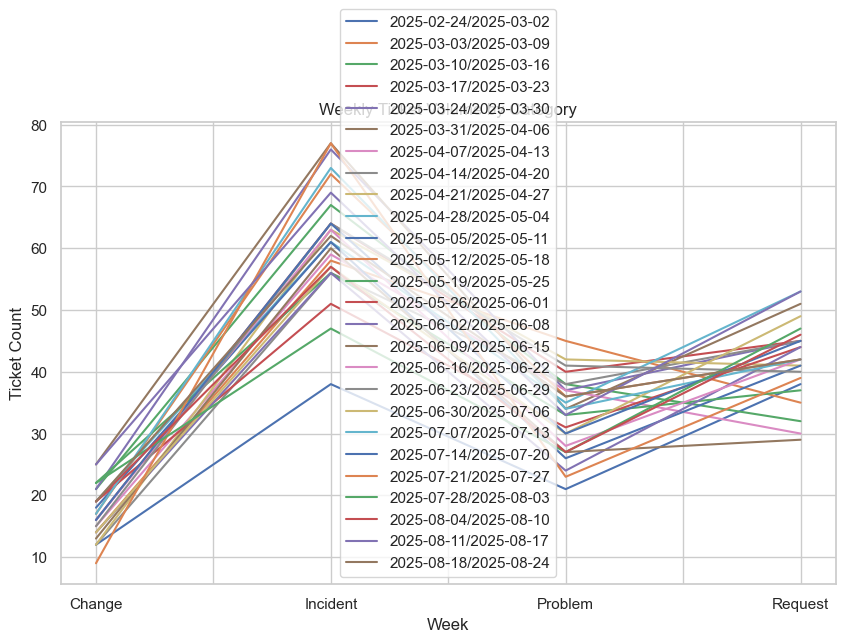

In [53]:
volume_df = pd.DataFrame(volume_trends['volume_data']).T
volume_df.plot(kind='line', figsize=(10,6))
plt.title('Weekly Ticket Volume by Category')
plt.xlabel('Week')
plt.ylabel('Ticket Count')
plt.show()

## Sentiment Trends

In [55]:
sentiment_trends = trend_detector.calculate_sentiment_trends(tickets, time_period='weekly')
sentiment_trends['sentiment_trends']

{'trend': 'decreasing',
 'percentage_change': -0.10729613733905588,
 'significance': 'low',
 'anomalies': [{'index': 0,
   'value': -0.064,
   'z_score': 2.5058653979469603,
   'period': '2025-02-24/2025-03-02'}],
 'mean': -0.22334615384615383,
 'std': 0.06358927098666398,
 'current_value': -0.208,
 'previous_value': -0.233}

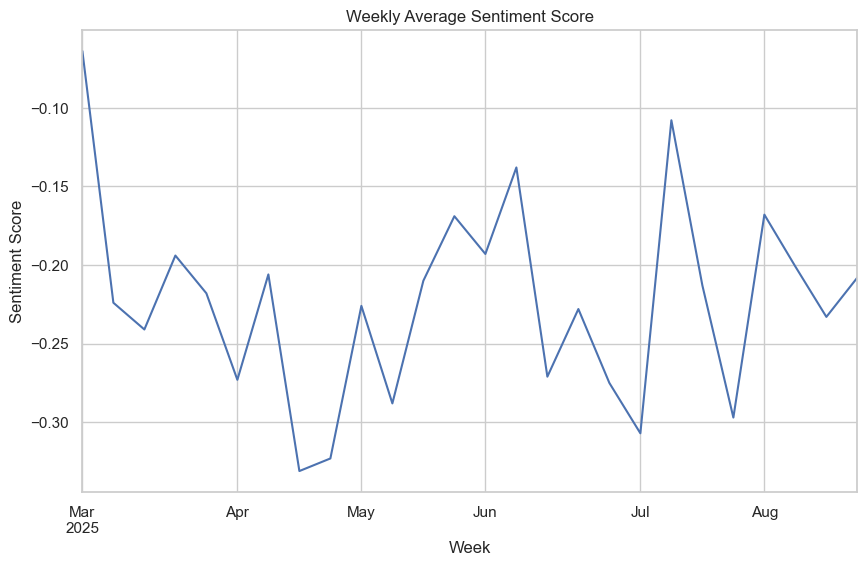

In [57]:
sentiment_df = pd.DataFrame(sentiment_trends['sentiment_data'])
sentiment_df[('sentiment_score','mean')].plot(kind='line', figsize=(10,6))
plt.title('Weekly Average Sentiment Score')
plt.xlabel('Week')
plt.ylabel('Sentiment Score')
plt.show()

## Anomaly Detection

In [64]:
# --- Detect anomalies ---
anomalies = trend_detector.detect_anomalies(tickets)
print(anomalies)

{'volume_anomalies': [], 'sentiment_anomalies': [], 'category_anomalies': [], 'confidence_anomalies': []}


## Alerts Generation

In [62]:
alerts = trend_detector.generate_alerts({**volume_trends, 'anomalies': anomalies})
alerts

[]

In [66]:
# --- Generate alerts ---
alerts = trend_detector.generate_alerts({**volume_trends, 'anomalies': anomalies})
print(alerts)

[]
